# DS UA 9201 - Recitation 4
author: Judith Abécassis (judith.abecassis@nyu.edu) & Elise Dumas (elise.dumas@nyu.edu)

Themes
- multiple testing simulation
- simpson's paradox (one one dataset)
- compute cate, stratification, variance... (on another dataset)

In [1]:
#Load useful libraries
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import CompareMeans, ztest 
import seaborn as sns
sns.set_context('poster')


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Problem 1: treatment effect heterogeneity, Analyzing an experiment on banking and savings

In "Savings Constraints and Microenterprise Development: Evidence from a Field Experiment in Kenya", Dupas and Robinson [studied](https://www.poverty-action.org/study/savings-accounts-rural-micro-entrepreneurs-kenya) evaluated the effect of offering access to free formal savings accounts on savings among a sample of Kenyan market vendors and bicycle-taxi drivers. Working in collaboration with a local community-owned "village bank" in Bumala Town, the researchers randomly selected 115 market vendors and bicycle-taxi drivers to be offered the option of opening a no-cost savings account subsidized by the researchers. 135 individuals acting as the control group were not prevented from opening an account, but were not given any assistance in opening an account.

We'll start by reading in the dataset


In [2]:
savings = pd.read_stata('dataset_savingsAEJ.dta')
savings = savings.dropna(subset=['bank_savings'])
savings.head()

,id,wave1,wave2,wave3,treatment,not_traced_account_opening,inlogs,filled_log,bg_gender,bg_boda,...,tot_flow_out,tot_flow_spouse,bank_savings,rosca_contrib,animal_savings,total_hours,investment,investment_t5,revenues,revenues_t5
1,364,1.0,0.0,0.0,0.0,NaN,1.0,1.000000,0,0.0,...,0.000000,-27.647058,23.529411,32.941177,0.000000,5.818627,398.529419,398.529419,365.722229,365.722229
3,366,1.0,0.0,0.0,0.0,NaN,1.0,1.000000,0,0.0,...,0.000000,NaN,0.000000,37.000000,1.166667,2.822222,1561.500000,146.734695,2625.666748,23.636364
4,367,1.0,0.0,0.0,0.0,NaN,1.0,0.925926,0,0.0,...,-22.400000,-15.600000,-0.800000,35.200001,17.400000,8.020833,156.600006,156.600006,90.000000,90.000000
5,368,1.0,0.0,0.0,0.0,NaN,1.0,0.988889,0,0.0,...,61.818180,-6.818182,2.272727,22.954546,0.000000,8.213825,277.897736,235.114944,236.685394,236.685394
6,369,1.0,0.0,0.0,0.0,NaN,1.0,0.977273,1,1.0,...,4.139535,7.674418,0.000000,0.000000,0.000000,5.139801,10.333333,10.333333,57.388062,57.388062


Some relevant variables are:

- `treatment` -- whether the participant received the option of opening an account (1) or not (0)
- `bg_gender` -- gender of the participant: 0 = female, 1 = male
- `bg_educ` -- number of years of education completed 
- `bg_age` -- age
- `bg_rosca` -- dummy=1 if participates in at least one ROSCA (Rotating Saving and Credit Associations)
- `bank_savings` -- LOGBOOK: average daily amount deposited into bank account 
- `exp_total` -- LOGBOOK: average daily total expenditure
- `exp_tot_private` -- LOGBOOK: average daily total private expenditures 

250 participants in the experiment were asked to fill out regular logbooks to record information about their expenditures, investment and saving habits (LOGBOOK).  Start by subsetting the data to the set of units that filled out the logbooks (not missing `bank_savings`)

### Question 1

Estimate the average treatment effect of the bank account offer on mean daily bank deposits using the simple difference-in-means estimator. Construct a 95\% confidence interval and interpret your results. What do you conclude about the ATE?

In [3]:
ate_hat = savings[savings.treatment==1].bank_savings.mean() - \
    savings[savings.treatment==0].bank_savings.mean()
print("our ATE estimate is ", ate_hat)

var_ate_hat = savings[savings.treatment==1].bank_savings.var() / len(savings[savings.treatment==1].bank_savings) + \
    savings[savings.treatment==0].bank_savings.var() / len(savings[savings.treatment==0].bank_savings)
print('our ATE variance estimate is', var_ate_hat)

our ATE estimate is  10.058885
our ATE variance estimate is 11.975098776702144


In [4]:
[ate_hat - sps.norm.ppf(0.975) * np.sqrt(var_ate_hat),
 ate_hat + sps.norm.ppf(0.975) * np.sqrt(var_ate_hat)]

[3.2764183417642734, 16.841350899568734]

The confidence interval does not contain zero.
We can also perform a statistical test, which exhibits a small p-value (think of the duality between hypothesis testing and confidence interval)

In [5]:
sps.ttest_ind(savings[savings.treatment==1].bank_savings.values,
             savings[savings.treatment==0].bank_savings.values,
              equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=2.9067673477053932, pvalue=0.003983321880348759)

### Question 2

Estimate the conditional average treatment effect of the bank account offer for men and for women respectively. Construct 95\% confidence intervals and interpret your results. Also test for the difference in treatment effects. Is the difference in treatment effects between men and women statistically significant at $\alpha = .05$?


In [6]:
ate_hat_men = savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings.mean() - \
    savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings.mean()
print("our ATE estimate for men is ", ate_hat_men)

ate_hat_women = savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings.mean() - \
    savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings.mean()
print("our ATE estimate for women is ", ate_hat_women)

our ATE estimate for men is  5.310898
our ATE estimate for women is  12.553999


In [7]:
var_ate_men = savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings.var() / len(savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings) + \
    savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings.var() / len(savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings)

ci_men = [ate_hat_men - sps.norm.ppf(0.975) * np.sqrt(var_ate_men),
 ate_hat_men + sps.norm.ppf(0.975) * np.sqrt(var_ate_men)]

print("confidence interval for CATE in men", ci_men)

var_ate_women = savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings.var() / len(savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings) + \
    savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings.var() / len(savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings)

ci_women = [ate_hat_women - sps.norm.ppf(0.975) * np.sqrt(var_ate_women),
 ate_hat_women + sps.norm.ppf(0.975) * np.sqrt(var_ate_women)]

print("confidence interval for CATE in women", ci_women)

confidence interval for CATE in men [-1.4518835075204173, 12.073679161817292]
confidence interval for CATE in women [3.0247230750061753, 22.083274819280934]


We can also perform a statistical test. Be aware that there are several implementations of statistical tests in Python (and in other languages). Those implementations can give slightly different results due to not having the same default parameters, but for the scope of this lecture, we will ignore those subtilities.

In [8]:
print(sps.ttest_ind(savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings.values,
             savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings.values,
              equal_var=False, nan_policy='omit'))
CompareMeans.from_data(savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings.values,
             savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings.values).summary()

Ttest_indResult(statistic=1.5391844878008465, pvalue=0.1296281992607334)


,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,5.3109,3.396,1.564,0.122,-1.449,12.071


In [9]:
print(sps.ttest_ind(savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings.values,
             savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings.values,
              equal_var=False, nan_policy='omit'))
CompareMeans.from_data(savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings.values,
             savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings.values).summary()

Ttest_indResult(statistic=2.58208336472362, pvalue=0.010687319044089033)


,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,12.5540,4.948,2.537,0.012,2.786,22.322


In [10]:
cate_diff = ate_hat_men - ate_hat_women
print("our difference between CATEs is ", cate_diff)

our difference between CATEs is  -7.243101


In [11]:
se_cate_men = np.sqrt(savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings.var()/len(savings[(savings.treatment==1)&(savings.bg_gender==1)].bank_savings) + \
                    savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings.var()/len(savings[(savings.treatment==0)&(savings.bg_gender==1)].bank_savings))
se_cate_women = np.sqrt(savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings.var()/len(savings[(savings.treatment==1)&(savings.bg_gender==0)].bank_savings) + \
                    savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings.var()/len(savings[(savings.treatment==0)&(savings.bg_gender==0)].bank_savings))
se_cate_diff = np.sqrt(se_cate_men**2 + se_cate_women**2)

ci_ate_diff = [cate_diff - sps.norm.ppf(.975)*se_cate_diff, cate_diff + sps.norm.ppf(.975)*se_cate_diff]
print(ci_ate_diff)

[-18.928233127287335, 4.442030887297101]


### Question 3 

Subjects who were participants in at least one Rotating Saving and Credit Association (a common saving/lending mechanism in many African countries) tended to save more on average. Let's post-stratify on this variable. Estimate the average treatment effect on average daily bank deposits using a stratified difference-in-means estimator, stratifying on ROSCA participation. Generate a 95\% confidence interval. How does the standard error compare to your result in 1 -- were there large benefits to stratification on this particular variable?


In [12]:
# Drop if missing bg_rosca (this shouldn't matter since we've already dropped all "missing")
savings = savings.dropna(subset=['bg_rosca'])

savings.bg_rosca.value_counts()


1.0    185
0.0     65
Name: bg_rosca, dtype: int64

In [13]:
ate_rosca_0 = savings[(savings.treatment==1)&(savings.bg_rosca==0)].bank_savings.mean() - \
    savings[(savings.treatment==0)&(savings.bg_rosca==0)].bank_savings.mean()
print("our ATE estimate for rosca 0 is ", ate_rosca_0)

var_rosca_0 = savings[(savings.treatment==1)&(savings.bg_rosca==0)].bank_savings.var() / len(savings[(savings.treatment==1)&(savings.bg_rosca==0)].bank_savings)+\
    savings[(savings.treatment==0)&(savings.bg_rosca==0)].bank_savings.var() / len(savings[(savings.treatment==0)&(savings.bg_rosca==0)].bank_savings)
print('our ATE variance estimate for rosca 0 is', var_rosca_0)

ate_rosca_1 = savings[(savings.treatment==1)&(savings.bg_rosca==1)].bank_savings.mean() - \
    savings[(savings.treatment==0)&(savings.bg_rosca==1)].bank_savings.mean()
print("our ATE estimate for rosca 1 is ", ate_rosca_1)

var_rosca_1 = savings[(savings.treatment==1)&(savings.bg_rosca==1)].bank_savings.var() / len(savings[(savings.treatment==1)&(savings.bg_rosca==1)].bank_savings)+\
    savings[(savings.treatment==0)&(savings.bg_rosca==1)].bank_savings.var() / len(savings[(savings.treatment==0)&(savings.bg_rosca==1)].bank_savings)
print('our ATE variance estimate for rosca 1 is', var_rosca_1)

our ATE estimate for rosca 0 is  4.509239
our ATE variance estimate for rosca 0 is 9.125600106375558
our ATE estimate for rosca 1 is  12.01897
our ATE variance estimate for rosca 1 is 20.61788200827206


In [14]:
tau_block = ate_rosca_0 * len(savings[savings.bg_rosca==0]) / len(savings) + ate_rosca_1 * len(savings[savings.bg_rosca==1]) / len(savings)
print(tau_block)

10.066439647674562


In [15]:
var_tau_block = var_rosca_0 * (len(savings[savings.bg_rosca==0]) / len(savings))**2 + var_rosca_1 * (len(savings[savings.bg_rosca==1]) / len(savings))**2
print(var_tau_block)

11.907242754920766


## Problem 2: Simpson's paradox
Simpson's paradox is a phenomenon in probability and statistics in which a trend appears in several groups of data but disappears or reverses when the groups are combined. Simpson's paradox occurs when a third variable is associated with treatment assignement and potential outcomes, breaking the ignorability assumption. We are going to study medical data reporting the outcomes of two treatments for kidney stones, as well as the kidney stone size.

### Question 1: compute the ATE of treatment A, compared to treatment B. 
You may need to convert variables to numerical values. You can use the `map` method in pandas, or the `loc` in indexes.

In [16]:
kidney_data = pd.read_csv('kidney_stone.csv')
kidney_data.head()

,treatment,stone_size,outcome
0,B,large,success
1,B,small,success
2,B,small,success
3,A,small,success
4,B,small,success


In [17]:
kidney_data = kidney_data.assign(outcome_bin=kidney_data.outcome.map({'success': 1, 'failure': 0}))
kidney_data.sample(10)

,treatment,stone_size,outcome,outcome_bin
413,A,small,success,1
29,A,large,success,1
672,A,large,success,1
376,A,large,success,1
225,B,small,success,1
573,B,small,success,1
288,B,small,success,1
208,A,large,failure,0
442,A,large,success,1
426,A,small,success,1


In [18]:
ate = kidney_data[kidney_data.treatment=='A'].outcome_bin.mean() -\
    kidney_data[kidney_data.treatment=='B'].outcome_bin.mean()
print('ATE:', ate)

ATE: -0.04571428571428571


### Question 2: now compute the CATEs for each stone size category.

In [19]:
cate_big = kidney_data[(kidney_data.treatment=='A') & (kidney_data.stone_size=='large')].outcome_bin.mean() -\
    kidney_data[(kidney_data.treatment=='B') & (kidney_data.stone_size=='large')].outcome_bin.mean()
print('CATE large size:', cate_big)

CATE large size: 0.04253802281368824


In [20]:
cate_small = kidney_data[(kidney_data.treatment=='A') & (kidney_data.stone_size=='small')].outcome_bin.mean() -\
    kidney_data[(kidney_data.treatment=='B') & (kidney_data.stone_size=='small')].outcome_bin.mean()
print('CATE small size:', cate_big)

CATE small size: 0.04253802281368824


### Question 3: are you surprised by the results? what are the treated and controlled proportions for each stone size? what is the effect of stone size on success? Can you explain the paradox?

The less effective treatment B appears to be more effective because it was applied more frequently to the small stones cases, which were easier to treat.

In [21]:
kidney_data.groupby('stone_size').outcome_bin.mean()

stone_size
large    0.720117
small    0.882353
Name: outcome_bin, dtype: float64

In [22]:
kidney_data.pivot_table(values='outcome', index='treatment', columns='stone_size',
               aggfunc='count')

stone_size,large,small
treatment,,
A,263,87
B,80,270


## Problem 3: multiple hypothesis testing simulation

We have discussed in class the issue of multiple hypothesis testing. Let's see it in practice. The objective is to simulate data where there is no treatment effect, and see what happens to our statistical tests.

### Question 1: complete the following function that simulates data and performs tests to assess our type I error rate?
We are exploring how likely it is to find a covariate the determines a subgroup where our treatment has a significant effect (different from zero).

In [23]:

def subgroup_sim(rng, n_iter, n_cov=20, N=2000, alpha=0.05):
    """
    this is a docstring
    n_iter : integer, nb of simulated datasets
    n_cov : integer, nb of covariates in our dataset
    N : integer, number of units in each simulated dataset
    alpha : statistical risk to reject the null hypothesis of 0 causal effect
    """
    reject = np.zeros(n_iter)
    
    for idx in range(n_iter):
        # simulate potential outcomes (standard normal distribution)
        Y_1 = Y_0 = rng.normal(0,1, N)
        # treatment
        T = rng.binomial(1, 0.5, N)
        # outcome (binary)
        Y = T * Y_1 + (1 - T) * Y_0
        # covariates (binary)
        X = rng.binomial(1, 0.3, [N, n_cov])
        
        
        # subgroup analysis
        for k in range(n_cov):
            cov_k_mask = X[:, k] == 1
            sub_T = T[cov_k_mask]
            sub_Y = Y[cov_k_mask]
            pv = ztest(sub_Y[sub_T==1], sub_Y[sub_T==0])[1]
            if pv < alpha:
                reject[idx] = 1
                break
    return np.mean(reject)
     

In [24]:
rng = np.random.default_rng(seed=256)
nb_covariates = [2, 5, 10, 20, 40, 60, 80, 100]
res = list()
for nc in nb_covariates:
    res.append(subgroup_sim(rng, 1000, n_cov=nc, N=2000, alpha=0.05))
print(res)

[0.104, 0.186, 0.361, 0.544, 0.74, 0.865, 0.908, 0.94]


Let's review the code together.


**why is $Y_1 = Y_0$?**
*because it's the null hypothesis of no effect. It's actually stronger, but easier to generate.*

**what is the command `break` doing?**
*it is stopping the loop before looking at all the covariates, we just need one*

Let's now plot the results!!

Text(0, 0.5, 'type 1 error')

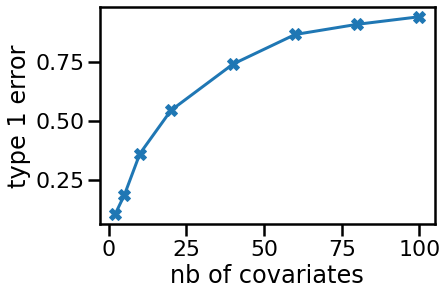

In [25]:
plt.plot(nb_covariates, res, marker='X')
plt.xlabel('nb of covariates')
plt.ylabel('type 1 error')

Let's now consider what happens when we introduce a "sample-splitting" step -- We randomly split our sample in half, go through each covariate and test for a "significant" effect in that group. If we find a significant effect, we check to see if we also detect a "significant" effect for that group in the other half of the sample. What's our false positive rate then?

In [26]:

def subgroup_sim_split(rng, n_iter, n_cov=20, N=2000, alpha=0.05, split=0.5):
    """
    this is a docstring
    n_iter : integer, nb of simulated datasets
    n_cov : integer, nb of covariates in our dataset
    N : integer, number of units in each simulated dataset
    alpha : statistical risk to reject the null hypothesis of 0 causal effect
    """
    reject = np.zeros(n_iter)
    
    for idx in range(n_iter):
        # simulate potential outcomes (standard normal distribution)
        Y_1 = Y_0 = rng.normal(0,1, N)
        # treatment
        T = rng.binomial(1, 0.5, N)
        # outcome (binary)
        Y = T * Y_1 + (1 - T) * Y_0
        # covariates (binary)
        X = rng.binomial(1, 0.3, [N, n_cov])
        
        # Sample indices to put in the "exploratory" sample
        exploratory_sample = rng.choice(N, int(N*split), replace=False)
        # Exploratory and confirmatory samples
        Y_explore = Y[exploratory_sample]
        T_explore = T[exploratory_sample]
        X_explore = X[exploratory_sample, :]

        # "tilde" is the negation
        Y_confirm = Y[~exploratory_sample] 
        T_confirm = T[~exploratory_sample]
        X_confirm = X[~exploratory_sample, :]
    
        # subgroup analysis
        to_evaluate = list()
        for k in range(n_cov):
            cov_k_mask = X_explore[:, k] == 1
            sub_T = T_explore[cov_k_mask]
            sub_Y = Y_explore[cov_k_mask]
            pv = ztest(sub_Y[sub_T==1], sub_Y[sub_T==0])[1]
            if pv < alpha:
                to_evaluate.append(k)
        
        for k in to_evaluate:
            cov_k_mask = X_confirm[:, k] == 1
            sub_T = T_confirm[cov_k_mask]
            sub_Y = Y_confirm[cov_k_mask]
            pv = ztest(sub_Y[sub_T==1], sub_Y[sub_T==0])[1]
            if pv < alpha:
                reject[idx] = 1
                break
    return np.mean(reject)
     

In [27]:
rng = np.random.default_rng(seed=256)
nb_covariates = [2, 5, 10, 20, 40, 60, 80, 100]
res_split = list()
for nc in nb_covariates:
    res_split.append(subgroup_sim_split(rng, 1000, n_cov=nc, N=2000, alpha=0.05))
print(res)

[0.104, 0.186, 0.361, 0.544, 0.74, 0.865, 0.908, 0.94]


Text(0, 0.5, 'type 1 error')

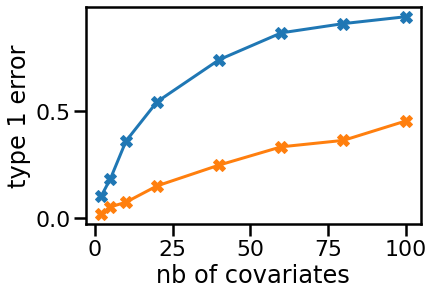

In [28]:
plt.plot(nb_covariates, res, nb_covariates, res_split, marker='X')
plt.xlabel('nb of covariates')
plt.ylabel('type 1 error')